# Image formation

- Given
    - World Coornidate 3D Points
    - Camera Intrinsic Parameter
    - Camera Orientation and Position
- Unknown
    - Image Plane 2D Points


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import csv
%matplotlib inline

Rotation Matrix   
$
R_x(\theta) = 
\begin{bmatrix} 
1 & 0 & 0 \\ 
0 & cos(\theta) & -sin(\theta) \\
 0 & sin(\theta) & cos(\theta) 
\end{bmatrix} 
$

$
R_y(\theta) = 
\begin{bmatrix} 
cos(\theta) & 0 & sin(\theta) \\
0 & 1 & 0 \\ 
-sin(\theta) & 0 & cos(\theta) 
\end{bmatrix} 
$

$
R_z(\theta) = 
\begin{bmatrix} 
cos(\theta) & -sin(\theta) & 0 \\
sin(\theta) & cos(\theta) & 0 \\
0 & 0 & 1 
\end{bmatrix} 
$

In [2]:
def RX(rx):
    return np.array([[1., 0, 0],
                     [0, math.cos(rx), -math.sin(rx)],
                     [0, math.sin(rx), math.cos(rx)]], dtype=np.float32)
    
def RY(ry):
    return np.array([[math.cos(ry), 0, math.sin(ry)],
                     [0, 1, 0],
                     [-math.sin(ry), 0, math.cos(ry)]], dtype=np.float32)

def RZ(rz):
    return np.array([[math.cos(rz), -math.sin(rz), 0],
                     [math.sin(rz), math.cos(rz), 0],
                     [0, 0, 1]], dtype=np.float32)

In [3]:
# read xyz file
# format Homogenous Coordinate
X = np.loadtxt("../bin/data/box.xyz")
X = np.hstack((X, np.ones((X.shape[0], 1)))).T
print(X.shape)

(4, 160)



### Camera Intrinsic Parameter

$
f = 1000, cx = 320, cy = 240 \\
K = \begin{bmatrix} f & 0 & cx \\ 0 & f & cy \\ 0 & 0 & 1 \end{bmatrix}
$

Camera Orientation and Position   
Projection Matrix P
$
\begin{aligned}
R_c &= R_z(\theta_z) R_y(\theta_y) R_x(\theta_x) \\
t_c &= \begin{bmatrix} t_x \\ t_y \\ t_z \end{bmatrix} \\
\\
R &= R_c^T \\
t &= -R_c^T t_c \\
P &= K [R|t] \\
\end{aligned}
$

In [4]:
# Camera Intrinsic Parameter
f, cx, cy = 1000, 320, 240
# Camera Orientation and Position
cam_ori = np.array([[0, 0, 0], [-np.pi/12 , np.pi/12, 0], [np.pi/12, -np.pi/12, 0], [np.pi/12, np.pi/12, 0], [-np.pi/12, -np.pi/12, 0]])
cam_pose = np.array([[0, 0, 0], [-2, -2, 0], [2, 2, 0], [-2, 2, 0], [2, -2 ,0]])
# image resolution
img_res = np.array([480, 640])
# set noise std
noise_std = 1

In [5]:
# Generate images for each camera pose
K = np.array([[f, 0, cx],
              [0, f, cy],
              [0, 0, 1]])
images = []
for i, (ori, pose) in enumerate(zip(cam_ori, cam_pose)):
    # Derive a projection Matrix
    Rc = RZ(ori[2]) @ RY(ori[1]) @ RX(ori[0])
    tc = pose
    R = Rc.T
    t = -Rc.T @ tc
    Rt = np.hstack((R, t.reshape(3, 1)))    
    P = K @ Rt
    
    # # Project the points
    x = P @ X # 3xN
    x /= x[2] # 3xN a, b, 1
    
    # # Add Gaussian Noise
    noise = np.random.normal(0, noise_std, size=(x.shape))
    x += noise
    
    # Show and store the points
    image = np.zeros(img_res)
    for p in x.T:
        if p[0] >= 0 and p[0] < image.shape[1] and p[1] >= 0 and p[1] < image.shape[0]:
            image = cv2.circle(image, (int(p[0]), int(p[1])), 2, 255, -1)
    images.append(image)
    # Save points file
    points_file = f"../bin/data/image_formation{i}.xyz"
    with open(points_file, 'wt') as f:
        for p in x.T:
            data = f"{p[0]} {p[1]} 1\n"
            f.write(data)    

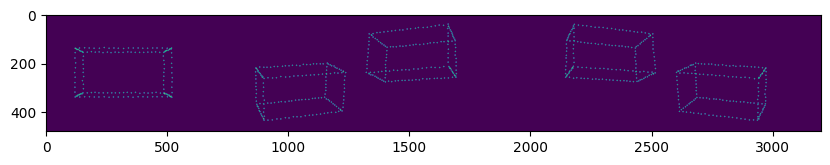

In [6]:
images = np.hstack(images)
plt.figure(figsize=(10, 20))
plt.imshow(images)